WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 135 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, τ, c, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 100 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


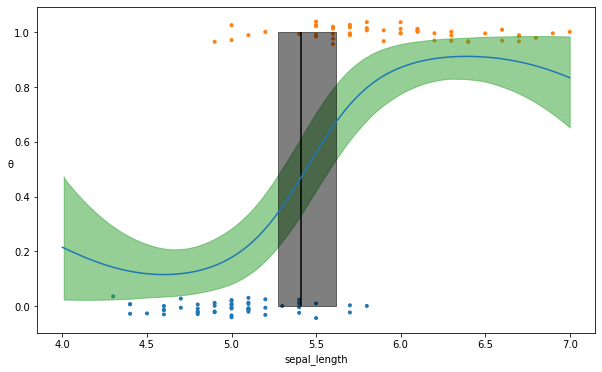

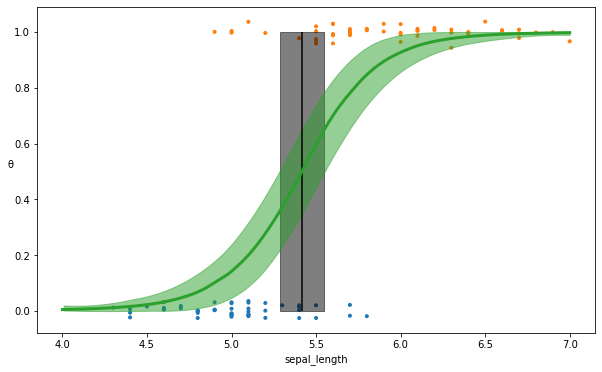

In [1]:
# Gaussian process binary classification in 1d
# Code is based on
# https://github.com/aloctavodia/BAP/blob/master/code/Chp7/07_Gaussian%20process.ipynb


try:
    import pymc3 as pm
except ModuleNotFoundError:
    %pip install -qq pymc3
    import pymc3 as pm
import numpy as np

try:
    import pandas as pd
except ModuleNotFoundError:
    %pip install -qq pandas
    import pandas as pd
from scipy import stats
from scipy.special import expit as logistic

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

import matplotlib.pyplot as plt

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

try:
    from sklearn.datasets import load_iris
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.datasets import load_iris


iris = load_iris()
X = iris.data
y = iris.target

# Convert to pandas dataframe
df_iris = pd.DataFrame(data=iris.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
df_iris["species"] = pd.Series(iris.target_names[y], dtype="category")


# Covnert to a two-class problem, and extract 1 feature to make 1d
df = df_iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df["species"]).codes
x_1 = df["sepal_length"].values
X_1 = x_1[:, None]

# For evaluating posterior predictive
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]


def find_midpoint(array1, array2, value):
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2


if 1:
    # Posterior over length scale l of kernel
    with pm.Model() as model_iris:
        # ℓ = pm.HalfCauchy("ℓ", 1)
        ℓ = pm.Gamma("ℓ", 2, 0.5)
        cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-5)
        gp = pm.gp.Latent(cov_func=cov)
        f = gp.prior("f", X=X_1)
        # logistic inverse link function and Bernoulli likelihood
        y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
        trace_iris = pm.sample(1000, chains=1, cores=1, compute_convergence_checks=False)

    # Posterior predictive

    with model_iris:
        f_pred = gp.conditional("f_pred", X_new)
        pred_samples = pm.sample_posterior_predictive(trace_iris, var_names=["f_pred"], samples=1000)

    # Plot results
    _, ax = plt.subplots(figsize=(10, 6))

    fp = logistic(pred_samples["f_pred"])
    fp_mean = np.mean(fp, 0)

    ax.plot(X_new[:, 0], fp_mean)
    # plot the data (with some jitter) and the true latent function
    ax.scatter(x_1, np.random.normal(y, 0.02), marker=".", color=[f"C{x}" for x in y])

    az.plot_hdi(X_new[:, 0], fp, color="C2")

    db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
    db_mean = db.mean()
    db_hpd = az.hdi(db)
    ax.vlines(db_mean, 0, 1, color="k")
    ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color="k", alpha=0.5)
    ax.set_xlabel("sepal_length")
    ax.set_ylabel("θ", rotation=0)
    pml.savefig("gp_classify_iris1.pdf", dpi=300)

# Change kernel to be sum of SE and linear, to improve tail behavior

with pm.Model() as model_iris2:
    # ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma("ℓ", 2, 0.5)
    c = pm.Normal("c", x_1.min())
    τ = pm.HalfNormal("τ", 5)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + τ * pm.gp.cov.Linear(1, c) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    trace_iris2 = pm.sample(1000, chains=1, cores=1, compute_convergence_checks=False)

with model_iris2:
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris2, var_names=["f_pred"], samples=1000)

_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples["f_pred"])
fp_mean = np.mean(fp, 0)

ax.scatter(x_1, np.random.normal(y, 0.02), marker=".", color=[f"C{ci}" for ci in y])

db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hdi(db)
ax.vlines(db_mean, 0, 1, color="k")
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color="k", alpha=0.5)

ax.plot(X_new[:, 0], fp_mean, "C2", lw=3)
az.plot_hdi(X_new[:, 0], fp, color="C2")

ax.set_xlabel("sepal_length")
ax.set_ylabel("θ", rotation=0)
pml.savefig("gp_classify_iris2.pdf", dpi=300)

plt.show()